# Анализ фондового рынка. 

<b>Описание проекта</b><br>
Из импортированных файлов  с информацией о динамике цен акций на фондовом рынке необходимо собрать датафрейм, осуществить предобработку, добавить метрики и провести исследовательский анализ цены за последние 3 года. В исследовании использовать скользящие средние, экспотенциальные скользящие средние и RSI индикатор.



**Задание**
1. Загрузите информацию об акциях (не менее пяти тикеров) с сайте finam.ru с параметрами:
Интервал: 3 года, периодичность 1 день.
Формат записи в файл:
<TICKER>	<PER>	<DATE>	<TIME>	<OPEN>	<HIGH>	<LOW>	<CLOSE>	<VOL>
https://www.finam.ru/quote/moex/gazp/export/
2. Соберите информацию из файлов в единый датафрейм (используйте дополнительные библиотеки).
3. Осуществите предобработку дат и заголовков.
4. Постройте линейные графики динамики цены для каждой акции (реализуйте в цикле).
5. Для каждой акции найдите дни максимального изменения цены (взлета и падения). Составьте отчет.
6. Найдите скользящие средние (периоды 10, 50, 100) для каждой акции. Добавьте на график.
7. Постройте в цикле графики объема (volume) для каждого тикера.
8. Реализуйте в цикле для каждого тикера последовательно: график цены вместе с скользящими средними с периодом 50, 100 и график объема, реализуйте с помощью функции. На вход функция принимает два параметра: тикер и год.
9. Добавьте экспоненциальные скользящие средние для каждого тикера с периодом 50.
10. Осуществите расчет индикатора RSI.
11.  Создайте функцию для вывода графиков: цены, скользящей средней (тип и период определите самостоятельно) и отдельный график для RSI индикатора. На графике с RSI добавьте две красные линии на уровнях 70 и 30. На вход функция принимает два параметра: тикер и год. <br>

Работу сопроводите комментариями к коду и выводами. 

**Дополнительная задача**<br>
Постройте модель прогноза цены акции

**Дополнительная информация**
1. Экпорт файлов осуществите с сайта:
https://www.finam.ru/quote/moex/gazp/export/
2. Для получения файлов из заданной директории используйте:

import glob<br>
globbed_files = glob.glob(path) # список файлов<br>

3. Информация про индикатор RSI
на БКС Экспресс:<br>
https://bcs-express.ru/novosti-i-analitika/indeks-otnositel-noi-sily-rsi-relative-strength-index<br>
Почитать еще про RSI:<br>
https://ru.tradingview.com/chart/BTCUSD/Eq8tysZA-indikator-rsi-sekrety-torgovli-pravila-primeneniya-polnyj-razbor/

3. Допустима загрузка исторических данных с помощью tinkoff invest api вместо экспорта с finam.ru

**Дополнительная задача**<br>
Постройте модель прогноза цены акции

### 1. Загрузите информацию об акциях 

In [1]:
# импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import t, norm
from scipy import stats as st
import glob

In [2]:
globbed_files = glob.glob("*.csv")
globbed_files

['GAZP.csv', 'LKOH.csv', 'MTSS.csv', 'SBER.csv', 'VKCO.csv']

### 2. Сбор единого датафрейма

In [3]:
df = pd.DataFrame()

for file in globbed_files:
    data = pd.read_csv(file, sep=';', index_col=False)
    data['filename'] = file
    df = pd.concat([df, data])

In [4]:
df = df.reset_index(False)
df# итоговый датафрейм

,index,TICKER,PER,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,filename
0,0,GAZP,D,201201,0,182.60,188.09,181.78,185.34,67193810,GAZP.csv
1,1,GAZP,D,201202,0,185.00,187.24,183.12,187.22,40191320,GAZP.csv
2,2,GAZP,D,201203,0,186.98,187.58,184.37,185.12,35885290,GAZP.csv
3,3,GAZP,D,201204,0,186.20,189.42,185.85,188.79,50684840,GAZP.csv
4,4,GAZP,D,201207,0,188.22,192.85,187.80,190.76,53512780,GAZP.csv
...,...,...,...,...,...,...,...,...,...,...,...
3694,714,VKCO,D,231127,0,624.80,625.00,611.20,613.60,1891743,VKCO.csv
3695,715,VKCO,D,231128,0,614.20,632.00,612.80,631.00,1592004,VKCO.csv
3696,716,VKCO,D,231129,0,633.00,644.00,620.00,625.80,1787913,VKCO.csv
3697,717,VKCO,D,231130,0,625.40,627.00,612.00,613.40,1345445,VKCO.csv


### 3. Осуществите предобработку дат и заголовков.

In [5]:
df.columns = ['index', 'ticker', 'per', 'date', 'time', 'open', 'high', 'low', 'close', 'vol', 'filename']
df

,index,ticker,per,date,time,open,high,low,close,vol,filename
0,0,GAZP,D,201201,0,182.60,188.09,181.78,185.34,67193810,GAZP.csv
1,1,GAZP,D,201202,0,185.00,187.24,183.12,187.22,40191320,GAZP.csv
2,2,GAZP,D,201203,0,186.98,187.58,184.37,185.12,35885290,GAZP.csv
3,3,GAZP,D,201204,0,186.20,189.42,185.85,188.79,50684840,GAZP.csv
4,4,GAZP,D,201207,0,188.22,192.85,187.80,190.76,53512780,GAZP.csv
...,...,...,...,...,...,...,...,...,...,...,...
3694,714,VKCO,D,231127,0,624.80,625.00,611.20,613.60,1891743,VKCO.csv
3695,715,VKCO,D,231128,0,614.20,632.00,612.80,631.00,1592004,VKCO.csv
3696,716,VKCO,D,231129,0,633.00,644.00,620.00,625.80,1787913,VKCO.csv
3697,717,VKCO,D,231130,0,625.40,627.00,612.00,613.40,1345445,VKCO.csv


Столбец time, per, filename можно убрать, так как в них всего одно значение или же как filename не имеет смысла

In [6]:
df = df.drop(['per', 'time', 'filename'], axis=1)
df

,index,ticker,date,open,high,low,close,vol
0,0,GAZP,201201,182.60,188.09,181.78,185.34,67193810
1,1,GAZP,201202,185.00,187.24,183.12,187.22,40191320
2,2,GAZP,201203,186.98,187.58,184.37,185.12,35885290
3,3,GAZP,201204,186.20,189.42,185.85,188.79,50684840
4,4,GAZP,201207,188.22,192.85,187.80,190.76,53512780
...,...,...,...,...,...,...,...,...
3694,714,VKCO,231127,624.80,625.00,611.20,613.60,1891743
3695,715,VKCO,231128,614.20,632.00,612.80,631.00,1592004
3696,716,VKCO,231129,633.00,644.00,620.00,625.80,1787913
3697,717,VKCO,231130,625.40,627.00,612.00,613.40,1345445


In [7]:
df.info() # "неправильными" типам данных является только столбец с датой

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3699 entries, 0 to 3698
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   3699 non-null   int64  
 1   ticker  3699 non-null   object 
 2   date    3699 non-null   int64  
 3   open    3699 non-null   float64
 4   high    3699 non-null   float64
 5   low     3699 non-null   float64
 6   close   3699 non-null   float64
 7   vol     3699 non-null   int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 231.3+ KB


Перейдем к обработке даты. Плохо, что для года используюся 2 последние цифры, хорошо, что это распространяется на все наблюдения

In [8]:
df['date'] = pd.to_datetime(df['date'], format='%y%m%d')
df

,index,ticker,date,open,high,low,close,vol
0,0,GAZP,2020-12-01,182.60,188.09,181.78,185.34,67193810
1,1,GAZP,2020-12-02,185.00,187.24,183.12,187.22,40191320
2,2,GAZP,2020-12-03,186.98,187.58,184.37,185.12,35885290
3,3,GAZP,2020-12-04,186.20,189.42,185.85,188.79,50684840
4,4,GAZP,2020-12-07,188.22,192.85,187.80,190.76,53512780
...,...,...,...,...,...,...,...,...
3694,714,VKCO,2023-11-27,624.80,625.00,611.20,613.60,1891743
3695,715,VKCO,2023-11-28,614.20,632.00,612.80,631.00,1592004
3696,716,VKCO,2023-11-29,633.00,644.00,620.00,625.80,1787913
3697,717,VKCO,2023-11-30,625.40,627.00,612.00,613.40,1345445


### 4. Постройте линейные графики динамики цены для каждой акции (реализуйте в цикле).

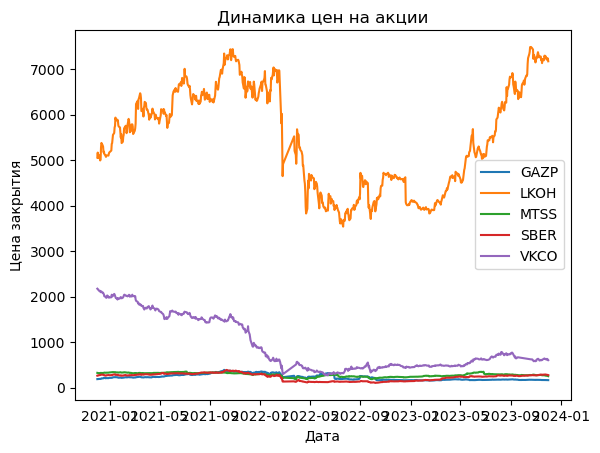

In [9]:
# Перебираем уникальные тикеры
for ticker in df['ticker'].unique():
    subset = df[df['ticker'] == ticker]
    plt.plot(subset['date'], subset['close'], label=ticker)
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.title('Динамика цен на акции')
plt.legend()
plt.show()

Как видно из графика на всем периоде цены акций лукойла были самыми высокими и в тоже время нестабильными, а самыми маленькие цены были на акции газпрома, а также самыми стабильными <br>
Откуда взялся 2024 год, я вообще не знаю

Графики в виде сабплотов

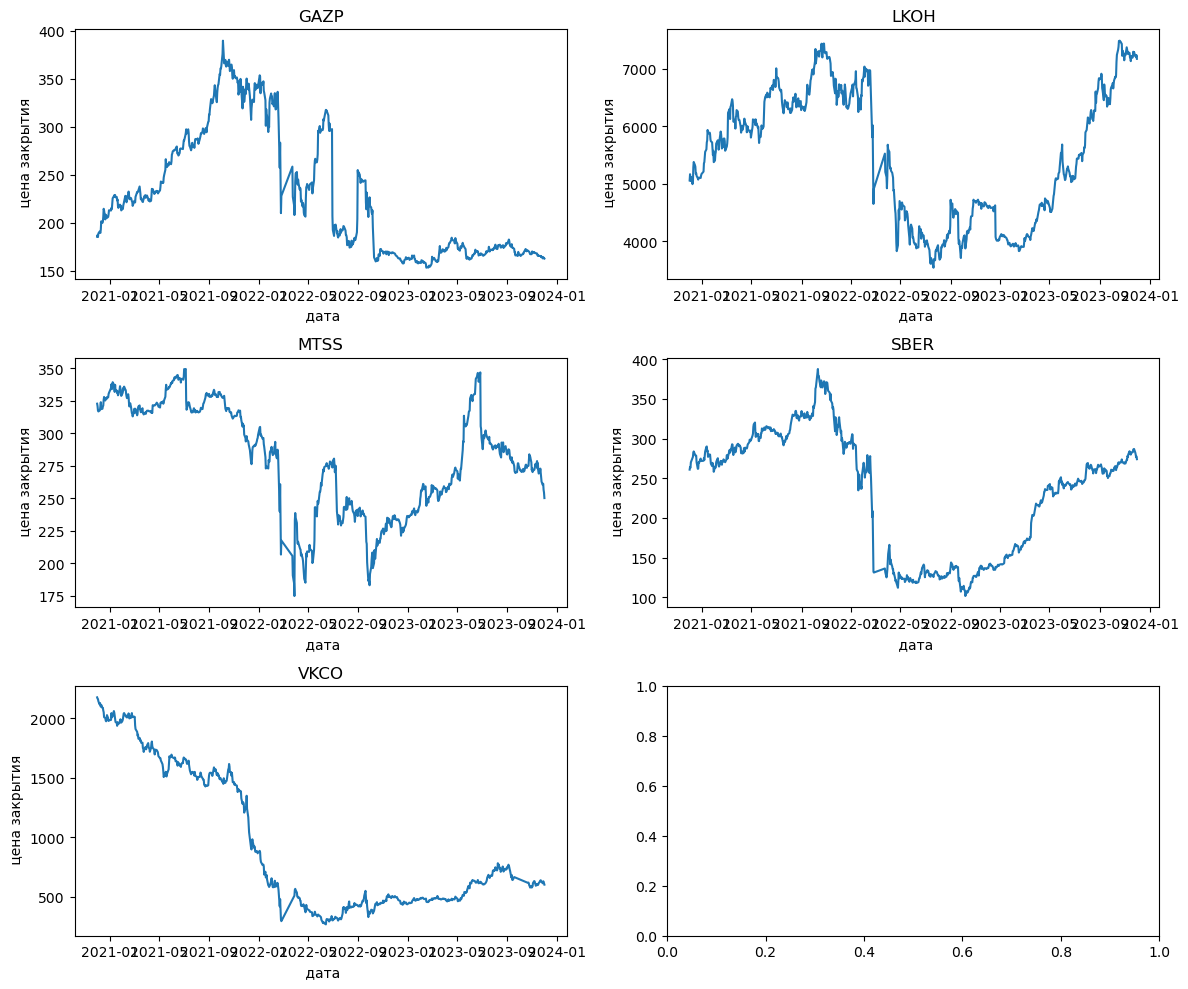

In [14]:
fig,axes = plt.subplots(3, 2, figsize = (12, 10))

for ticker, ax in zip(df['ticker'].unique(), axes.ravel()):
    subset = df[df['ticker'] == ticker]
    sns.lineplot(data = subset, x = 'date', y = 'close', ax = ax).set(title = ticker, xlabel = ' дата', ylabel = ' цена закрытия')
plt.tight_layout()

На графиках видно, что практически все цены акций компаний уменьшились в цене в феврале 2022 года. Это может быть связано с началом боевых действий на Укране. После этого цены акций компаний Лукойл, Сбербанк и МТС стали восстанавливаться быстрее. Цены акций Вконтакте и Газпром имеют самые медленные темпы роста среди этих компаний. Интересно, что цены акции компании Газпром имеют резкие всплески роста и падения в 2022 году. Такое колебание может объясняться решением совета директоров о выплате дивидендов

### 5. Для каждой акции найдите дни максимального изменения цены (взлета и падения). Составьте отчет

In [16]:
df['price_change'] = df['close'] - df['open'] # столбец с изменением цены
max_change_idx = df.groupby('ticker')['price_change'].idxmax() # группровка по компании (нахождение индекса)
report_df = df.loc[max_change_idx, ['ticker', 'date', 'price_change']] # составляем отчет
report_df

,ticker,date,price_change
312,GAZP,2022-02-22,29.56
1065,LKOH,2022-03-31,568.00
1809,MTSS,2022-03-30,55.80
2484,SBER,2021-11-23,20.56
3295,VKCO,2022-03-29,210.20


Максимальным изменением цены акций можно увидеть в таблице. Наибольший интерес предстваляют изменения цены акций лукойла, мтс и вконтакте, так как они произошли примерно в одно и тоже время - в конце марта 2022 года. Самое большое повышение цен произошло у акций компании "Лукойл"

In [17]:
min_change_idx = df.groupby('ticker')['price_change'].idxmin() # группровка по компании (нахождение индекса)
report_df = df.loc[min_change_idx, ['ticker', 'date', 'price_change']] # составляем отчет
report_df

,ticker,date,price_change
380,GAZP,2022-06-30,-92.60
1058,LKOH,2022-02-24,-750.00
1801,MTSS,2022-02-21,-33.25
2548,SBER,2022-02-24,-54.40
3291,VKCO,2022-02-21,-137.20


Минимальные изменения цены акция - в таблице. Падение цен акций лукойла, мтс, сбербанка и вконтакте можно объяснить влиянием санкций, в качестве дополнительного фактора может быть иностранная прописка эмитентов, которая повлияла на права акционеров и выплату дивидендов. Снижение цен на акции газпрома в июне 2022 года могло быть связано с "неодобренными" дивидендами за 2021 год, вследствии чего котировки газпрома обрушились

### 6. Найдите скользящие средние (периоды 10, 50, 100) для каждой акции. Добавьте на график.
P.S. Я не очень поняла, что значит 10, 50, 100, предполагаю, что это размер скользящих окон для расчета скользящих средних

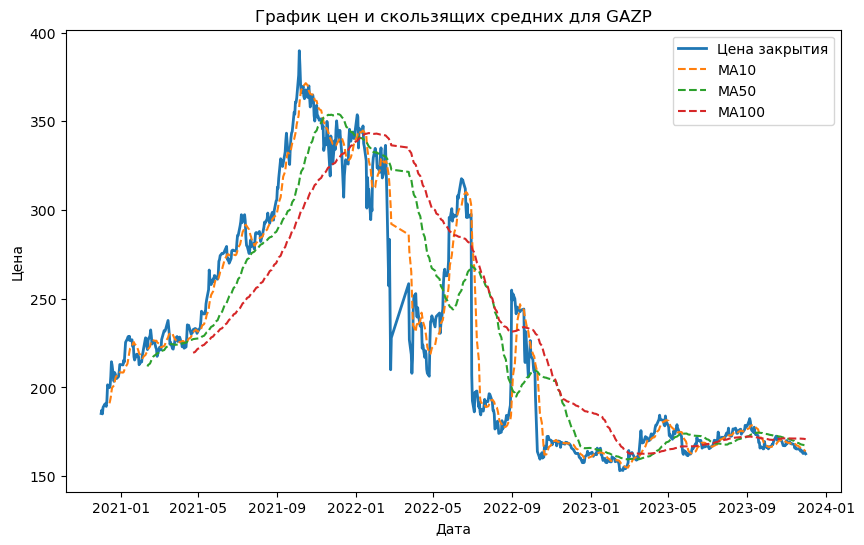

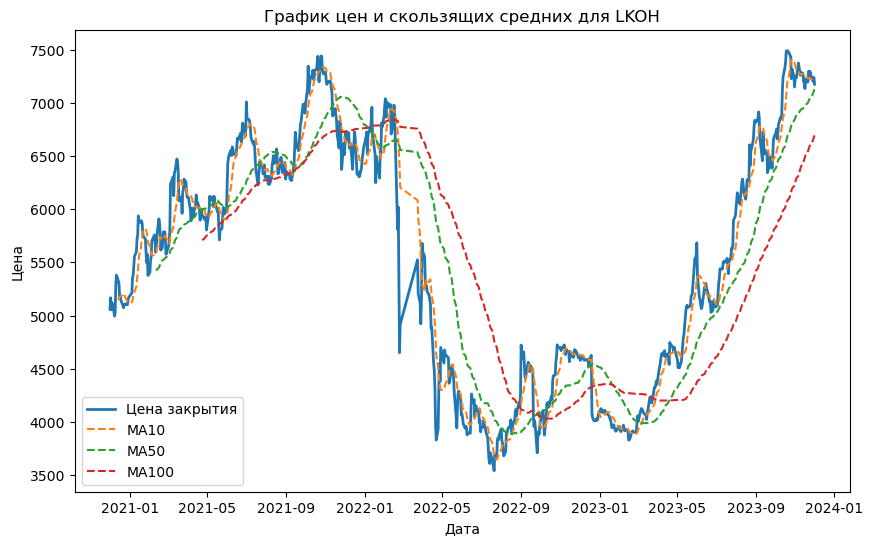

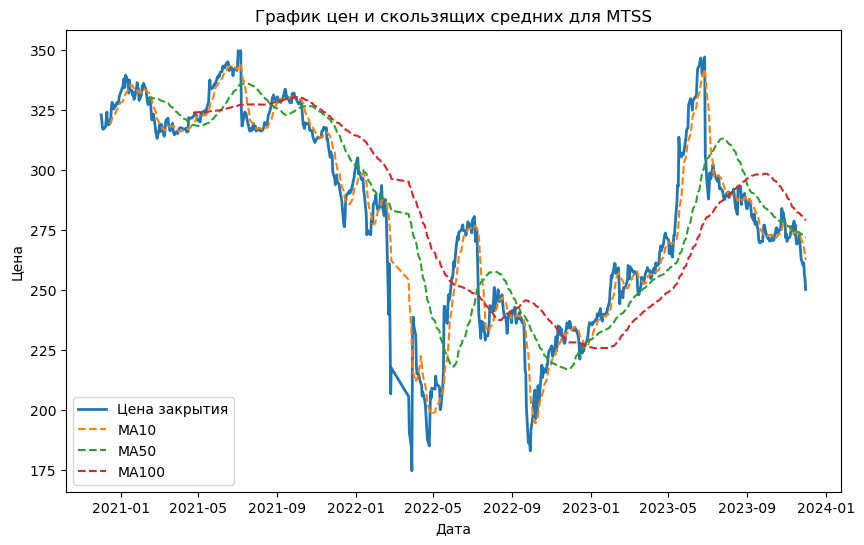

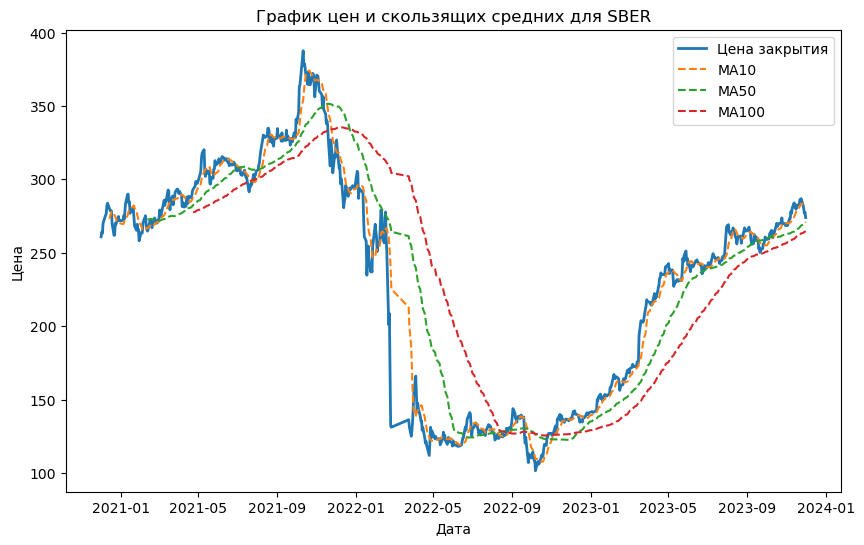

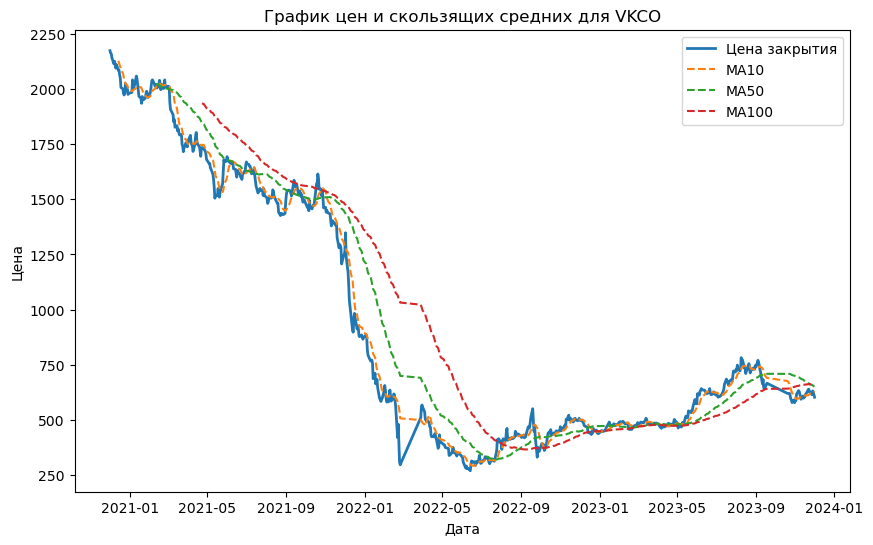

In [18]:
for ticker in df['ticker'].unique():
    subset = df[df['ticker'] == ticker].copy()
    subset['MA10'] = subset['close'].rolling(window=10).mean()
    subset['MA50'] = subset['close'].rolling(window=50).mean()
    subset['MA100'] = subset['close'].rolling(window=100).mean()
    # Строим график
    plt.figure(figsize=(10, 6))
    plt.plot(subset['date'], subset['close'], label='Цена закрытия', linewidth=2)
    plt.plot(subset['date'], subset['MA10'], label='MA10', linestyle='--')
    plt.plot(subset['date'], subset['MA50'], label='MA50', linestyle='--')
    plt.plot(subset['date'], subset['MA100'], label='MA100', linestyle='--')
    # Добавляем подписи и легенду
    plt.xlabel('Дата')
    plt.ylabel('Цена')
    plt.title(f'График цен и скользящих средних для {ticker}')
    plt.legend()
    plt.show()

Даже не знаю какие выводы тут можно сделать...<br>
Наиболее подходящим для прогнозирования является выборка из скользящих средних с размером скользящего окна в 100, так как он на всех графиках получился более плавным и устойчивым к изменениям, как и ожидалось

Графики в виде сабплотов

In [21]:
from datetime import datetime as dt

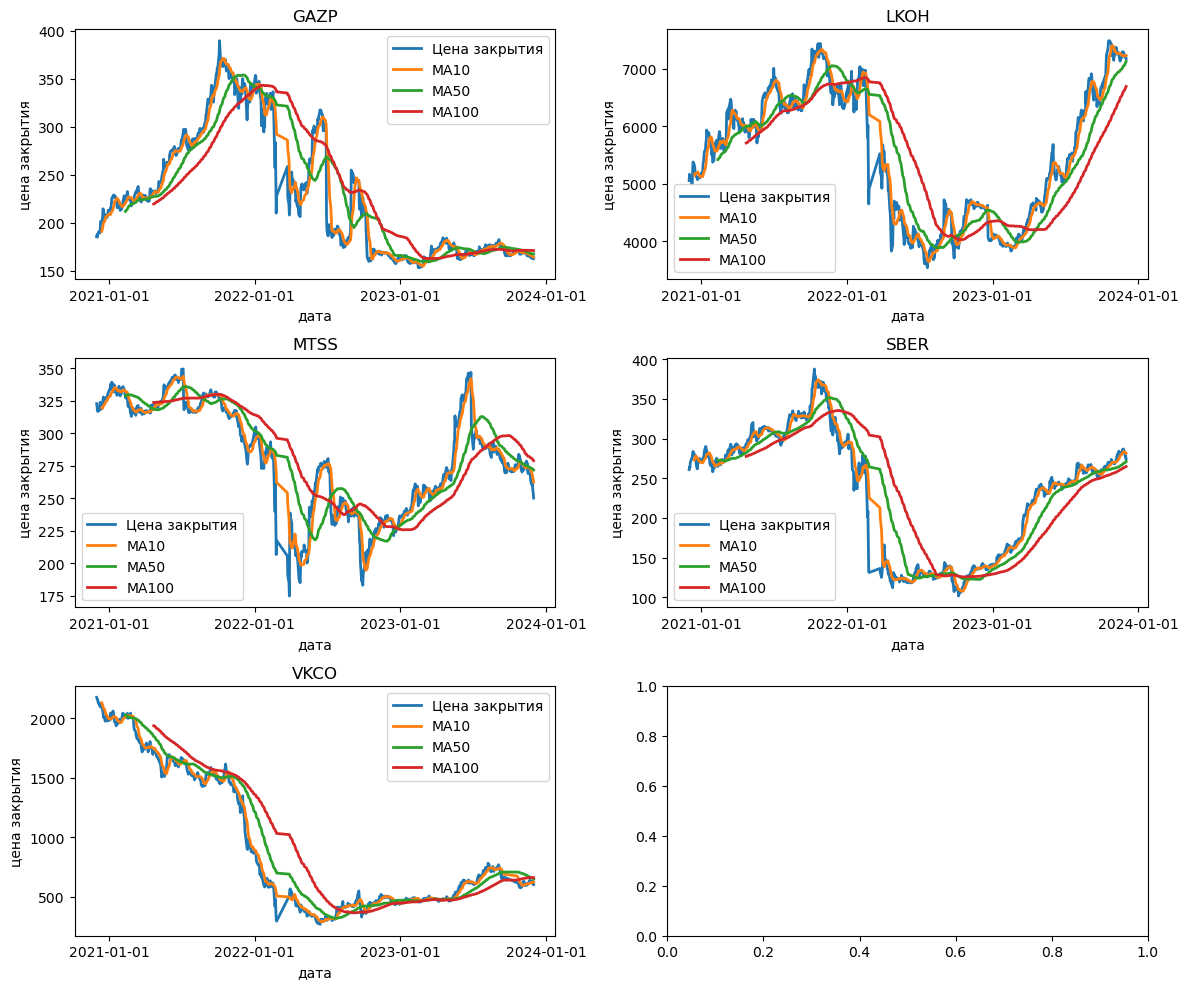

In [22]:
fig, axes = plt.subplots(3, 2, figsize = (12, 10))
for ticker, ax in zip(df['ticker'].unique(), axes.ravel()):
    subset = df[df['ticker'] == ticker].copy()
    subset['MA10'] = subset['close'].rolling(window=10).mean()
    subset['MA50'] = subset['close'].rolling(window=50).mean()
    subset['MA100'] = subset['close'].rolling(window=100).mean()
    # Строим график
    sns.lineplot(data = subset,x = 'date', y = 'close', label='Цена закрытия', linewidth=2, ax = ax).set(title = ticker, xlabel = 'дата', ylabel = 'цена закрытия', xticks = [dt(2021+i,1,1) for i in range(4)])
    sns.lineplot(data = subset,x = 'date', y = 'MA10', label='MA10', linewidth=2, ax = ax).set(title = ticker, xlabel = 'дата', ylabel = 'цена закрытия')
    sns.lineplot(data = subset,x = 'date', y = 'MA50', label='MA50', linewidth=2, ax = ax).set(title = ticker, xlabel = 'дата', ylabel = 'цена закрытия')
    sns.lineplot(data = subset,x = 'date', y = 'MA100', label='MA100', linewidth=2, ax = ax).set(title = ticker, xlabel = 'дата', ylabel = 'цена закрытия')
plt.tight_layout()

На данных графиках видно, что МА в 100 единиц некорректно показывает значения, а наиболее приближенным к реальности является МА в 10 единиц

### 7. Постройте в цикле графики объема (volume) для каждого тикера.

Почему все надо делать в циклах? Я от них уже отвыкла...

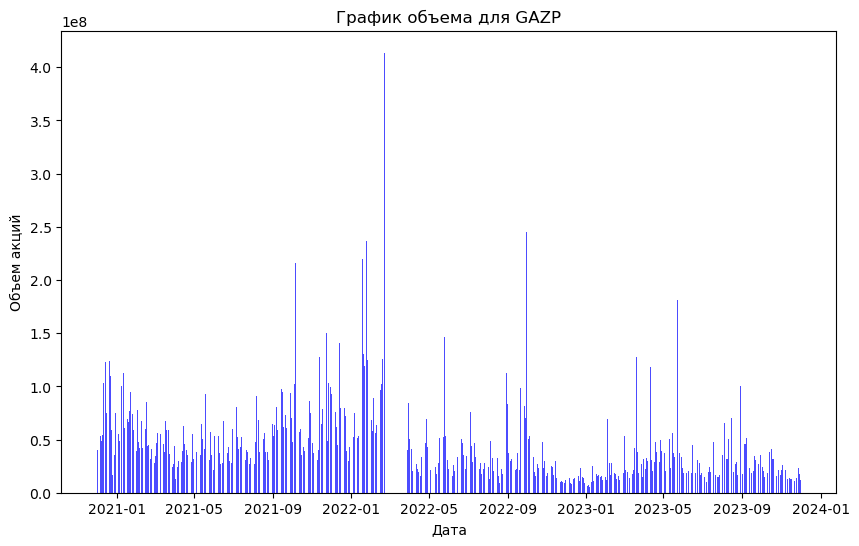

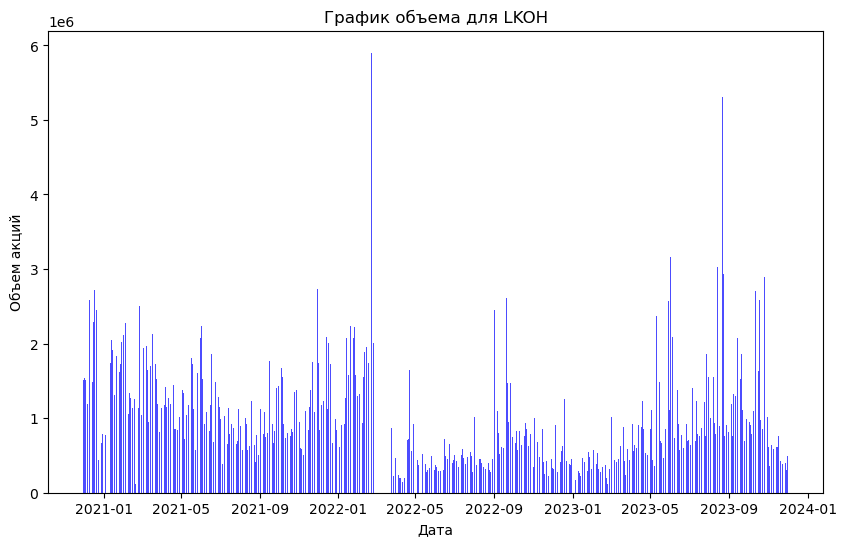

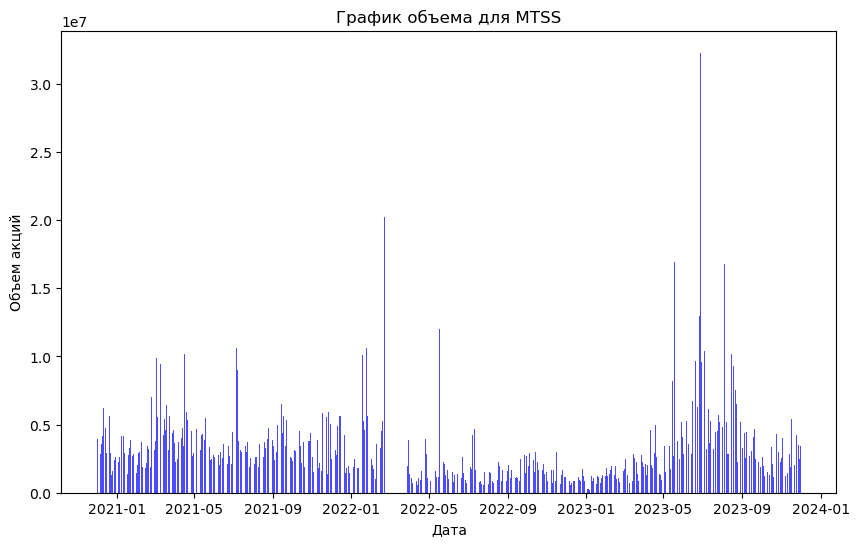

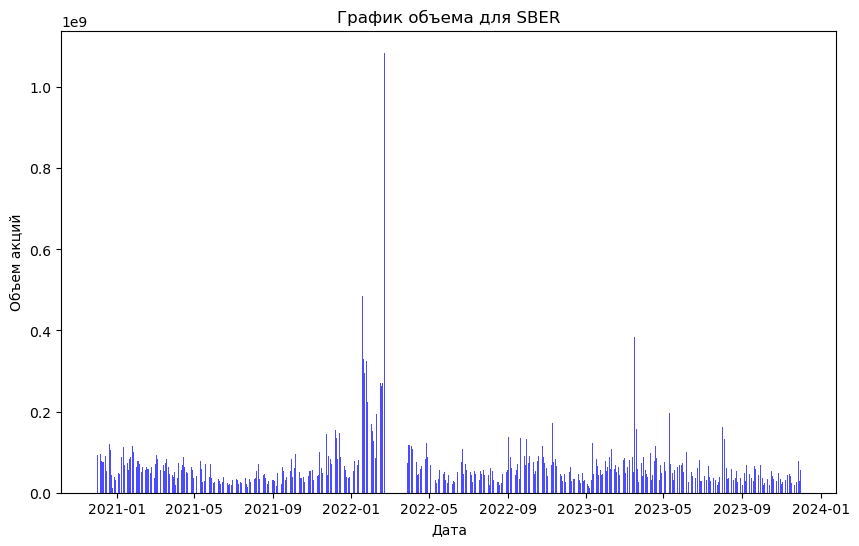

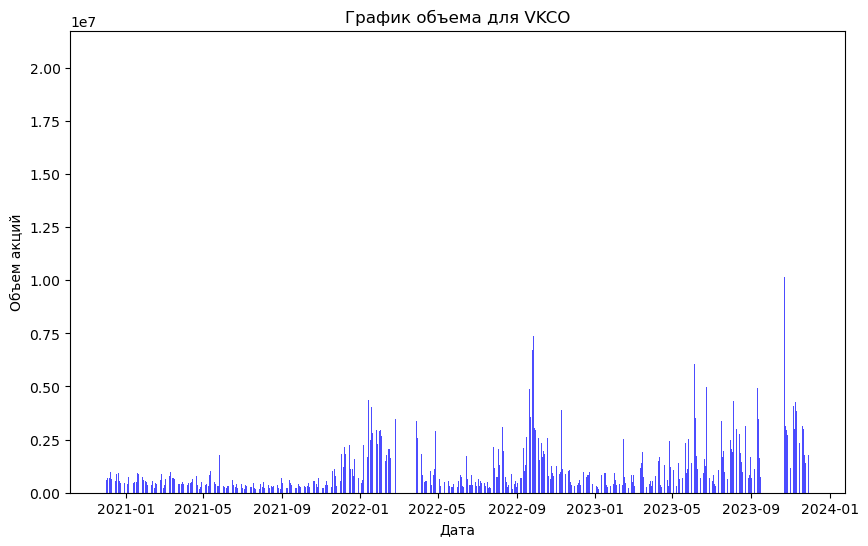

In [12]:
for ticker in df['ticker'].unique():
    subset = df[df['ticker'] == ticker]
    plt.figure(figsize=(10, 6))
    plt.bar(subset['date'], subset['vol'], color='blue', alpha=0.7)
    plt.xlabel('Дата')
    plt.ylabel('Объем акций')
    plt.title(f'График объема для {ticker}')
    plt.show()

На графиках видно, что всплеск объема купленных акций Газпром имеет определенную периодичность, это может быть связано с выплатами по двидендам. Также в 2022 году был период, когда акции Газпрома уменьшились в объемах. Это может быть связано с решением газпрома не выплачивать дивиденды за 2022 год. Акции Лукойл покупались в целом больше, чем остальные. На графике объема акций Сбербанка виден всплеск перед закрытием биржи в 2022 году. График акций Вконтакте показывает положительный тренд в увеличении объемов продажи.

преобразуем в сабплоты и также посмотрим на линейные графики

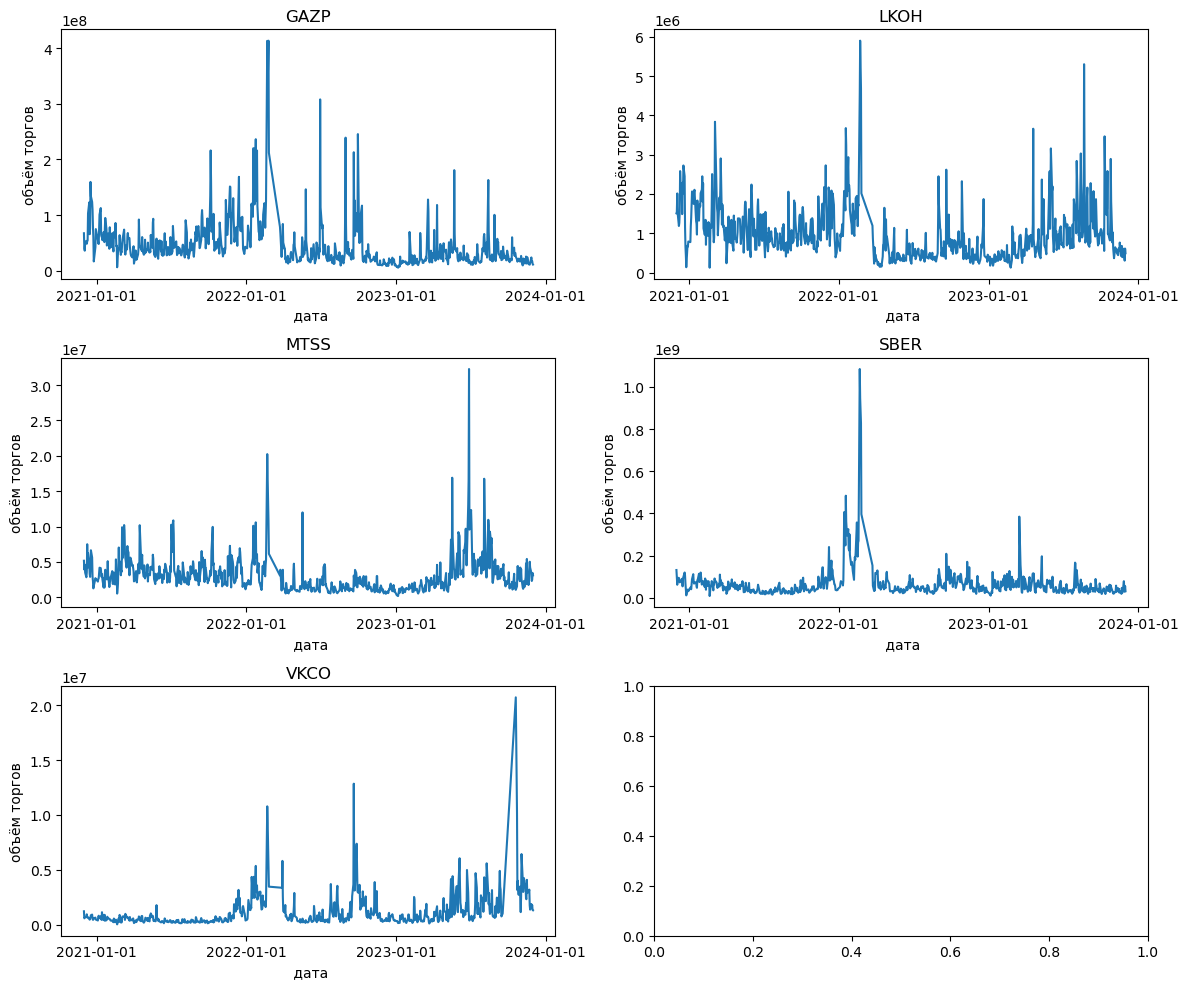

In [29]:
fig,axes = plt.subplots(3, 2, figsize = (12, 10))

for ticker, ax in zip(df['ticker'].unique(), axes.ravel()):
    subset = df[df['ticker'] == ticker]
    #sns.barplot(data = subset, x = 'date', y = 'vol', ax = ax).set(title = ticker, xlabel = ' дата', ylabel = 'объём торгов', xticks = [dt(2021+i,1,1) for i in range(4)])
    sns.lineplot(data = subset, x = 'date', y = 'vol', ax = ax).set(title = ticker, xlabel = ' дата', ylabel = 'объём торгов', xticks = [dt(2021+i,1,1) for i in range(4)])
plt.tight_layout()

По данным графикам лучше видно, что у вконтакте бакже есть периодические всплески в объемах акций, что так же может быть связано с выплатой дивидендов

### 8. Реализуйте в цикле для каждого тикера последовательно: график цены вместе с скользящими средними с периодом 50, 100 и график объема, реализуйте с помощью функции. На вход функция принимает два параметра: тикер и год.

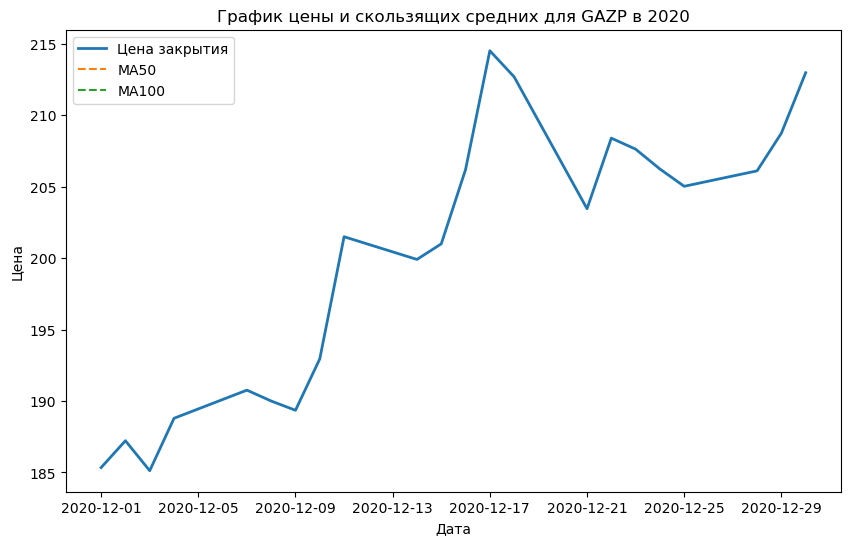

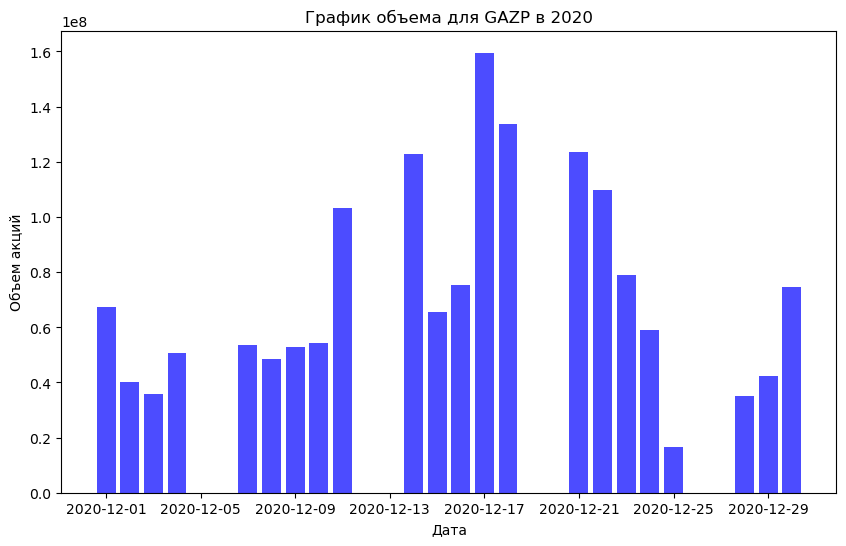

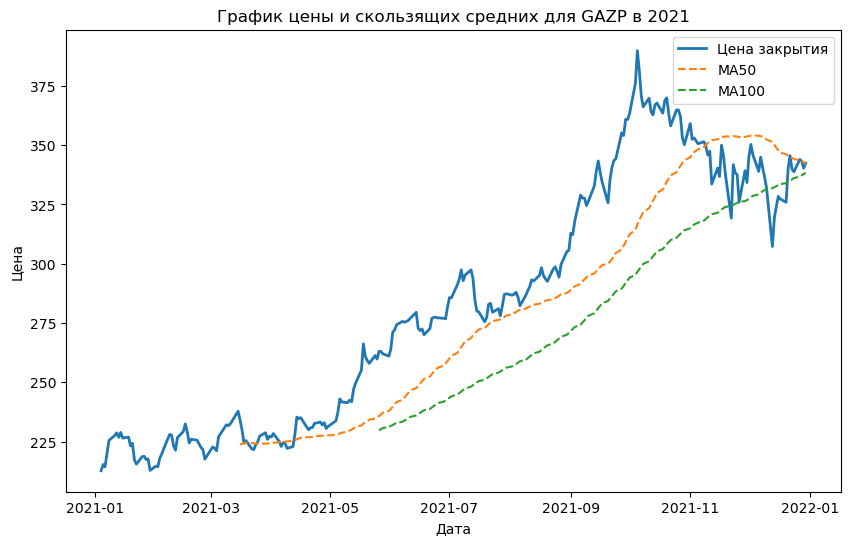

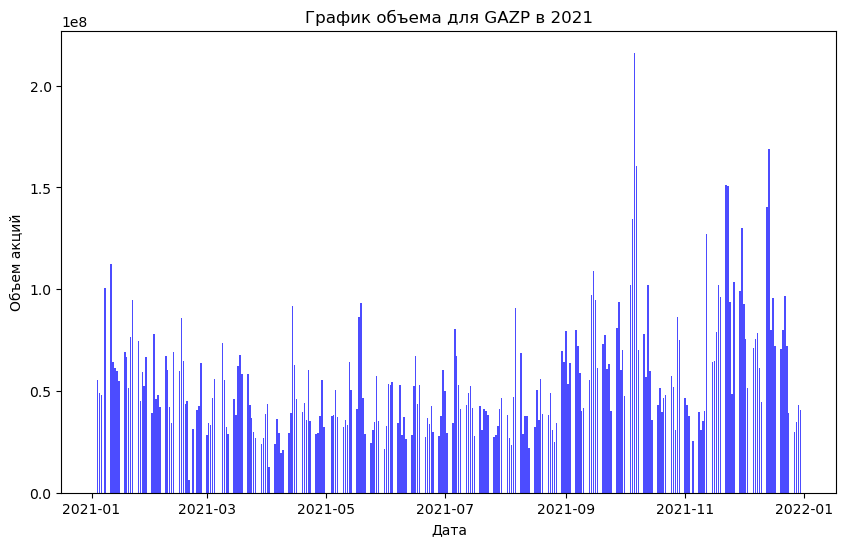

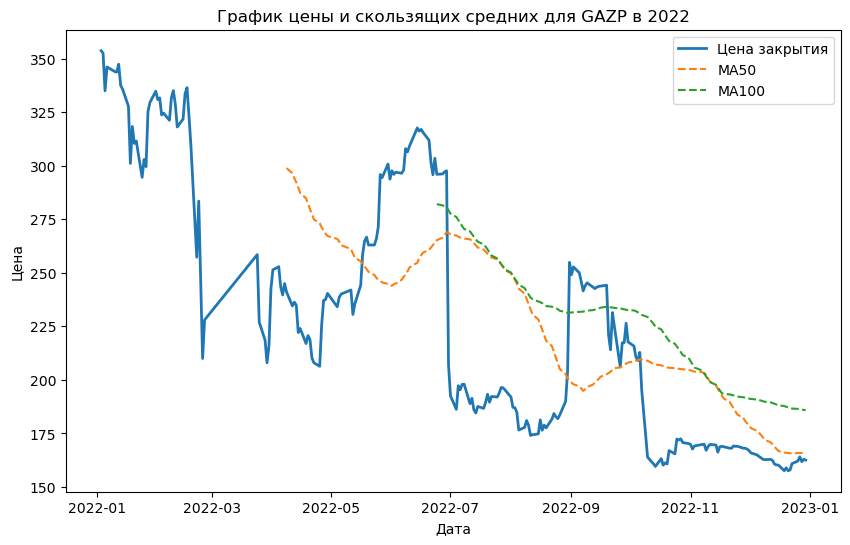

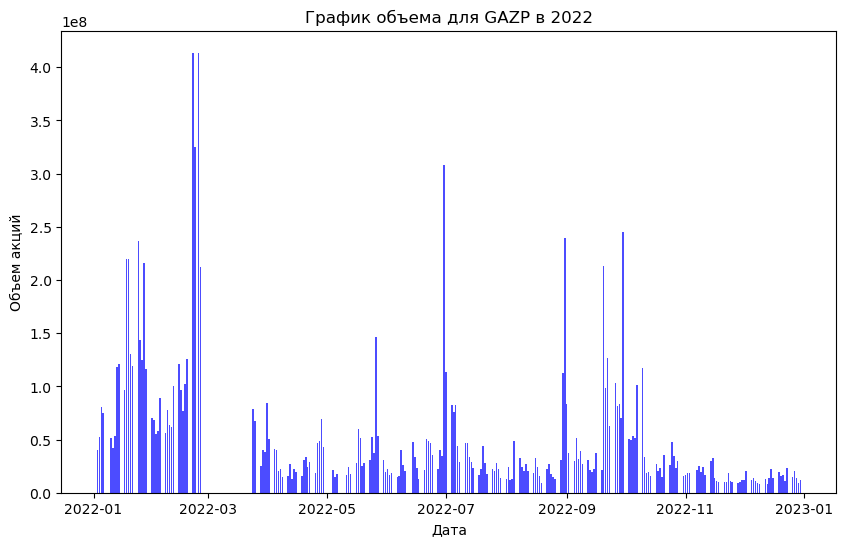

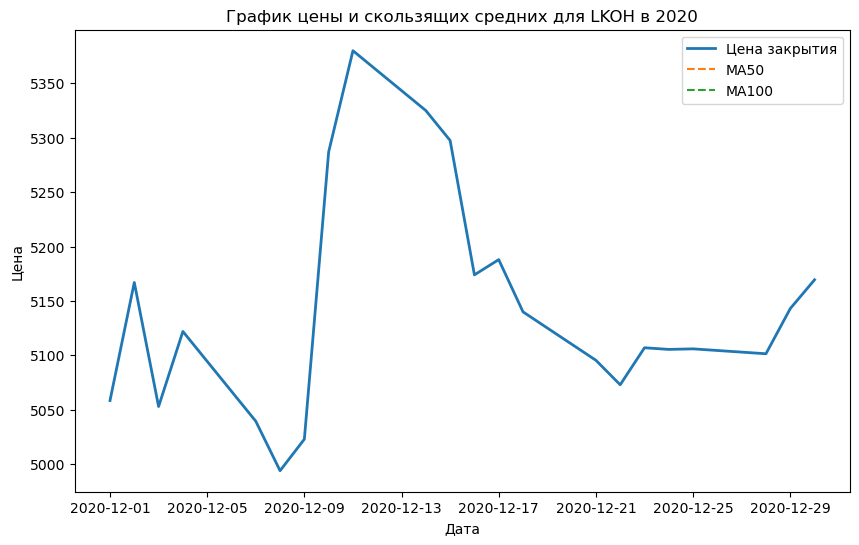

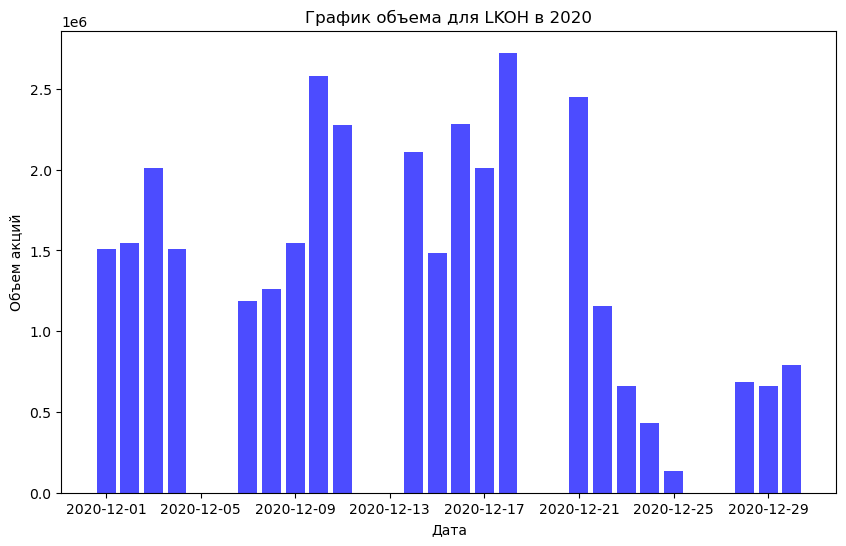

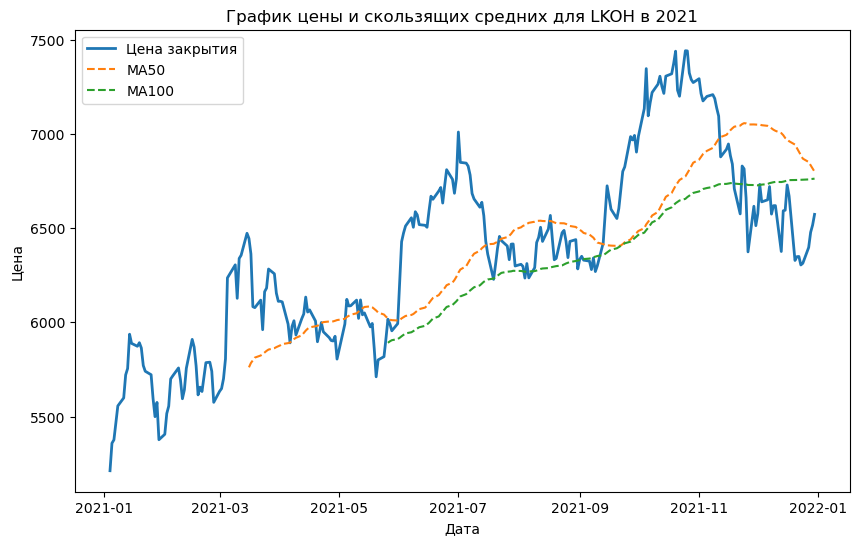

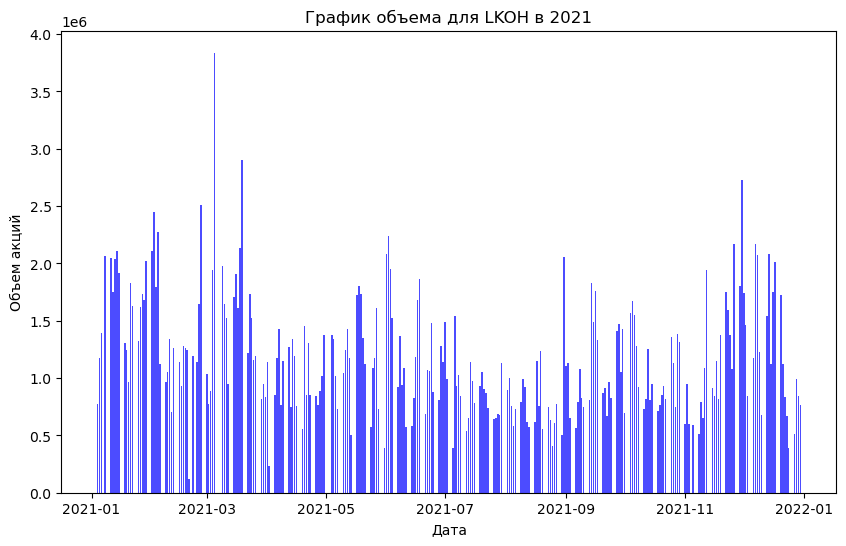

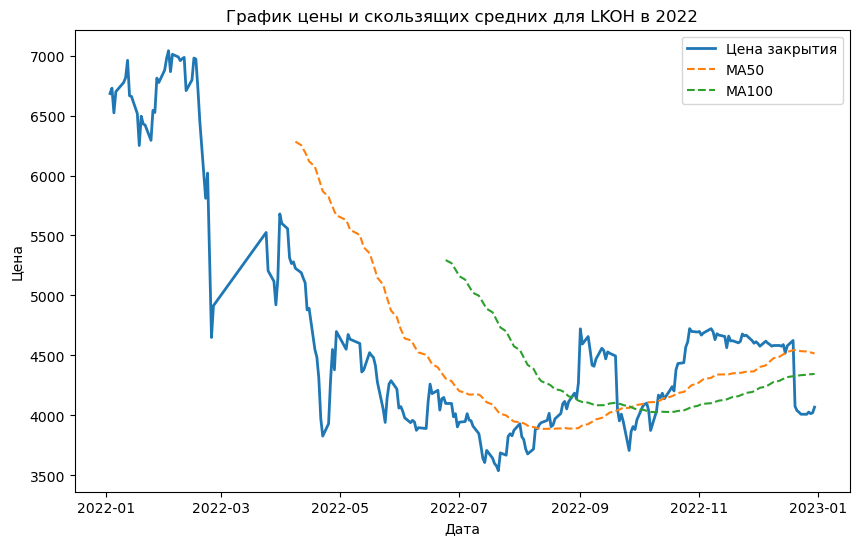

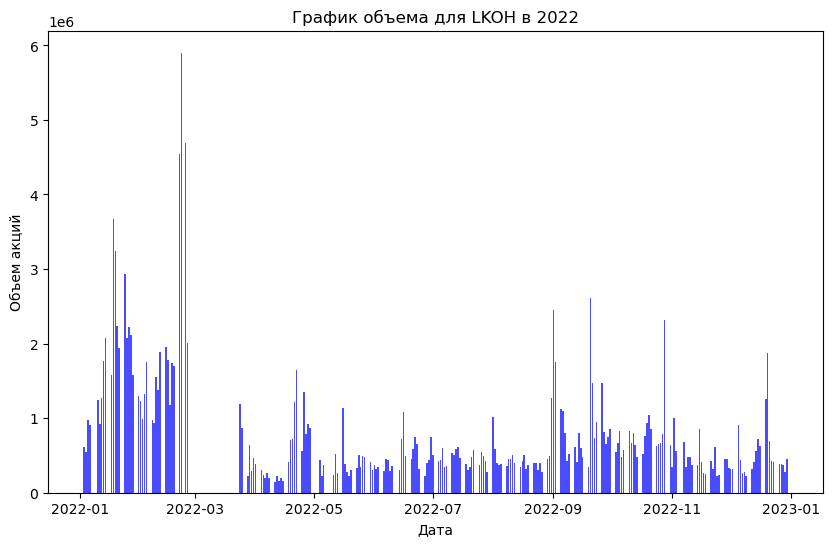

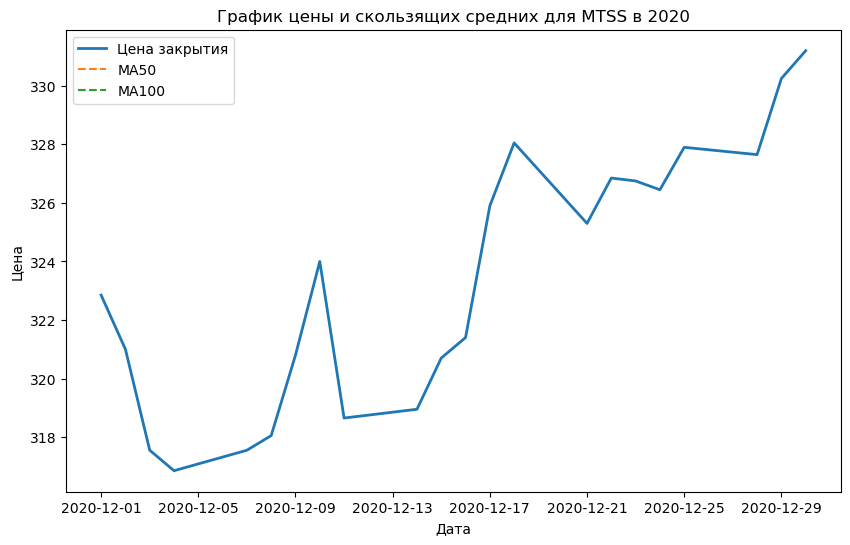

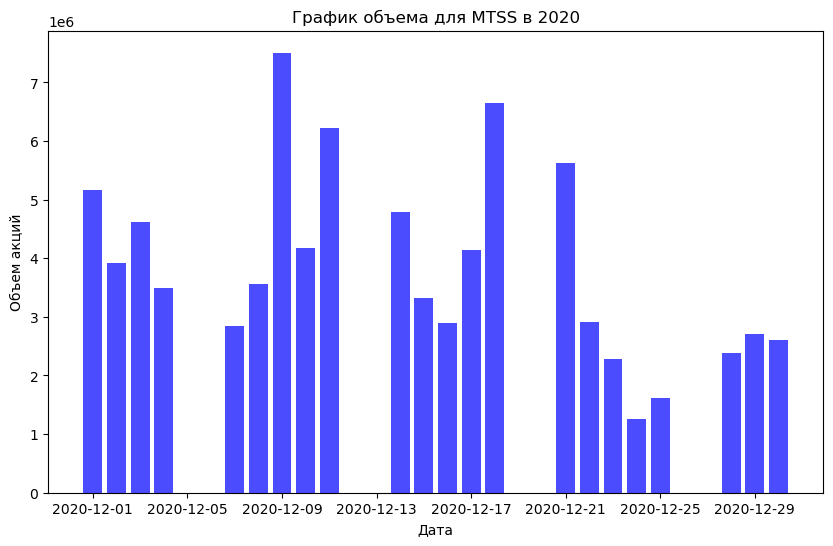

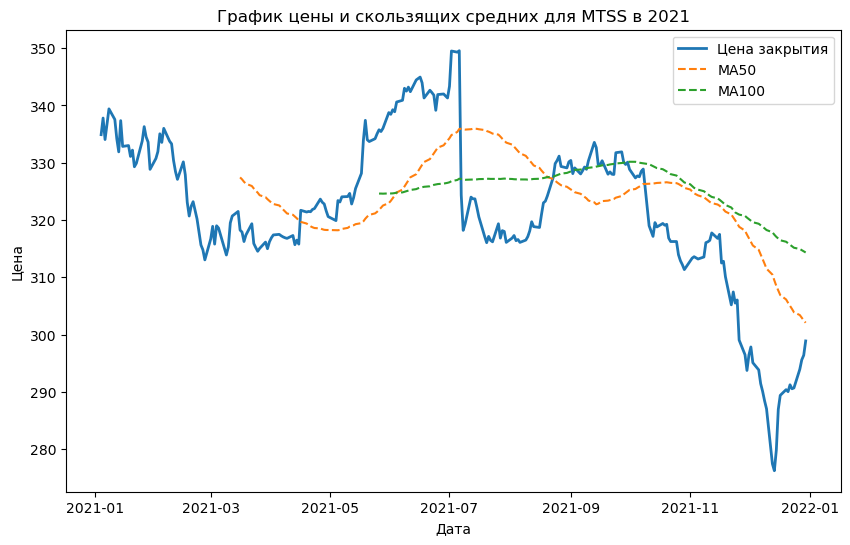

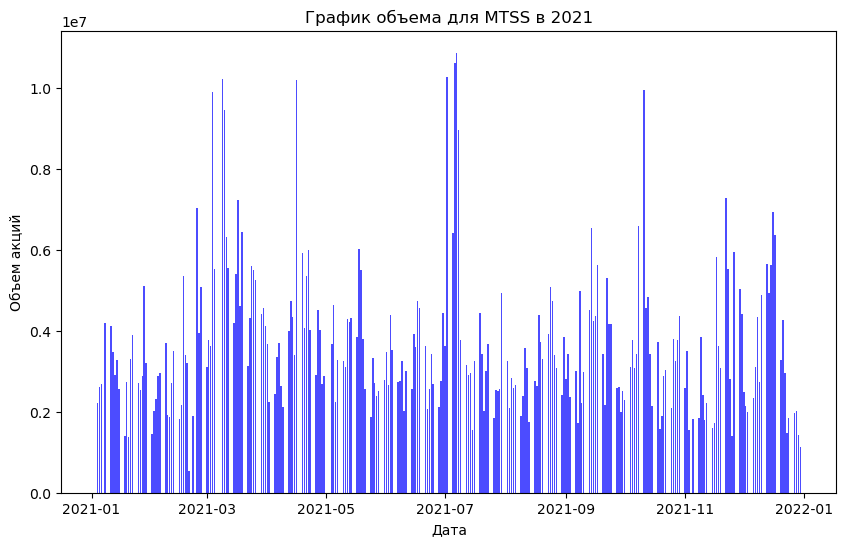

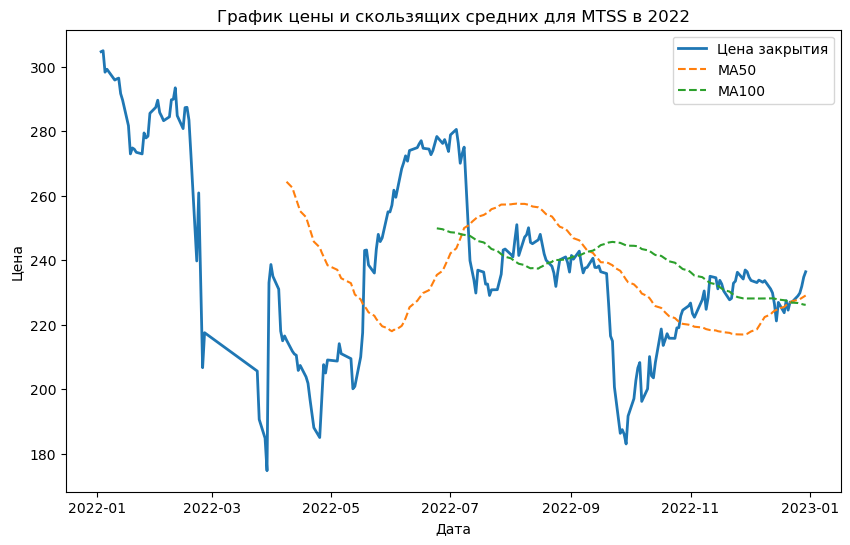

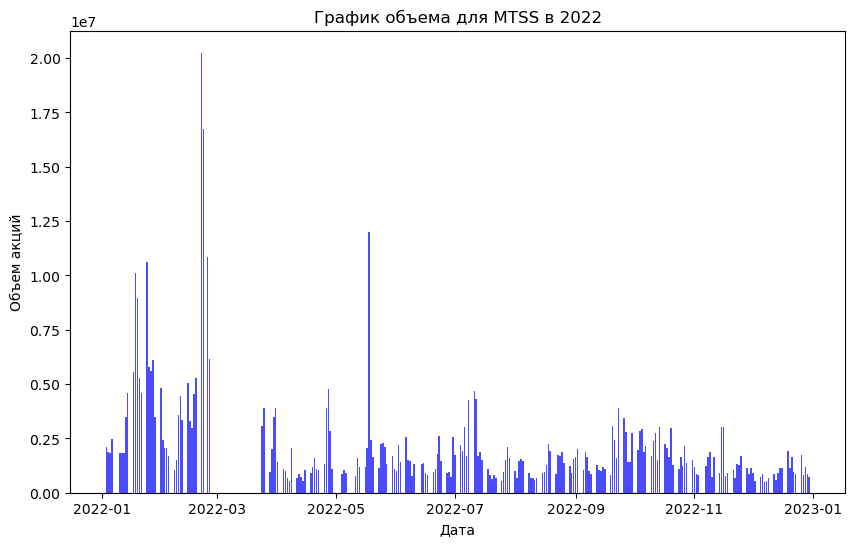

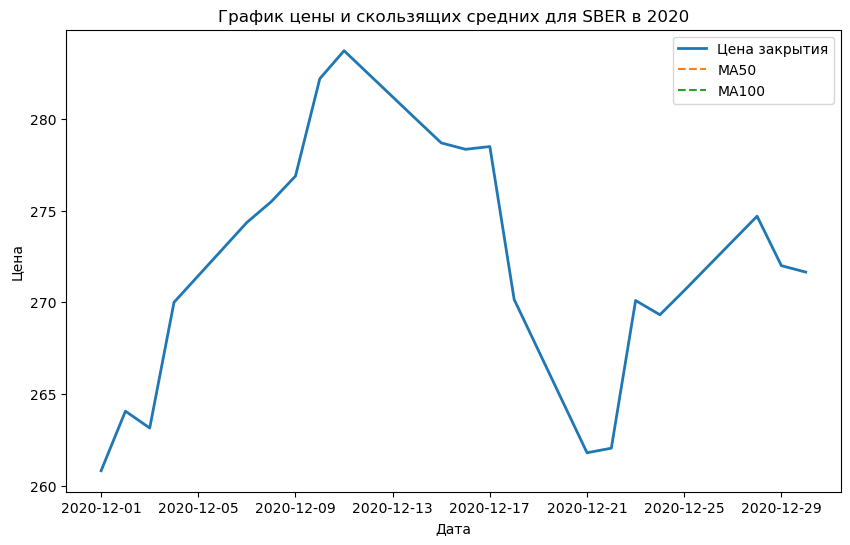

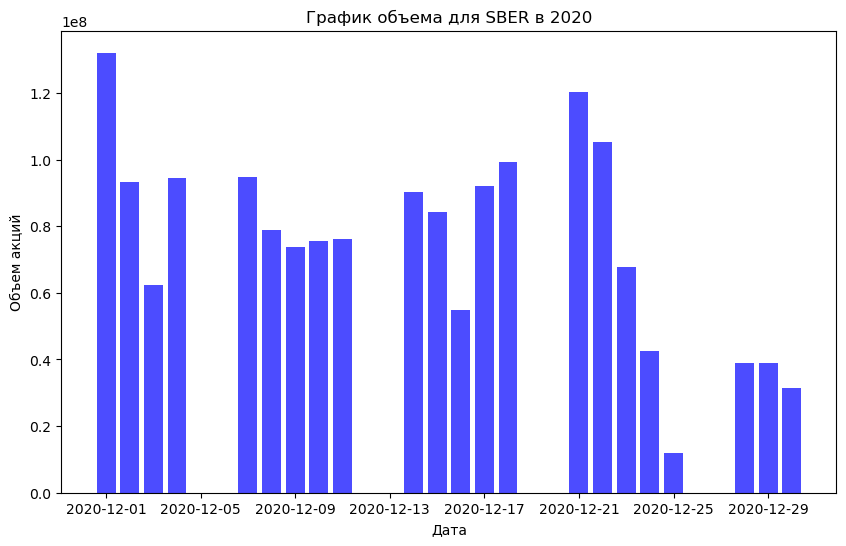

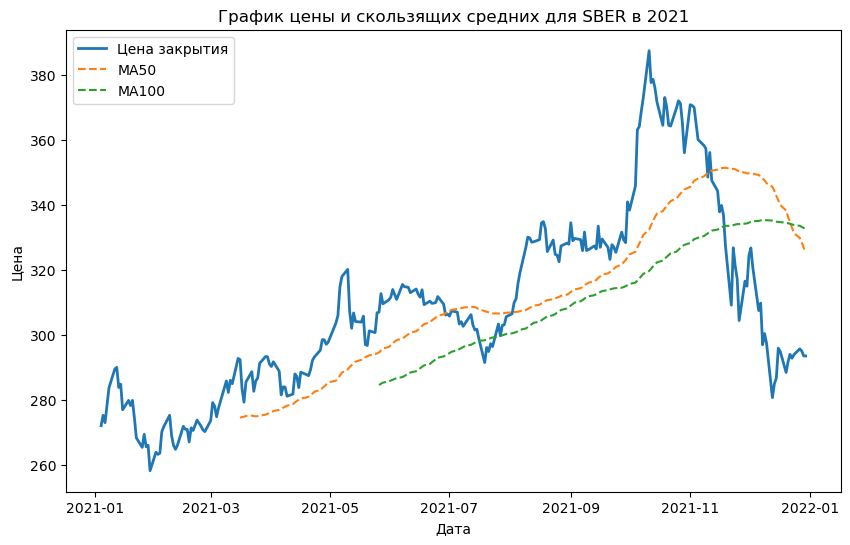

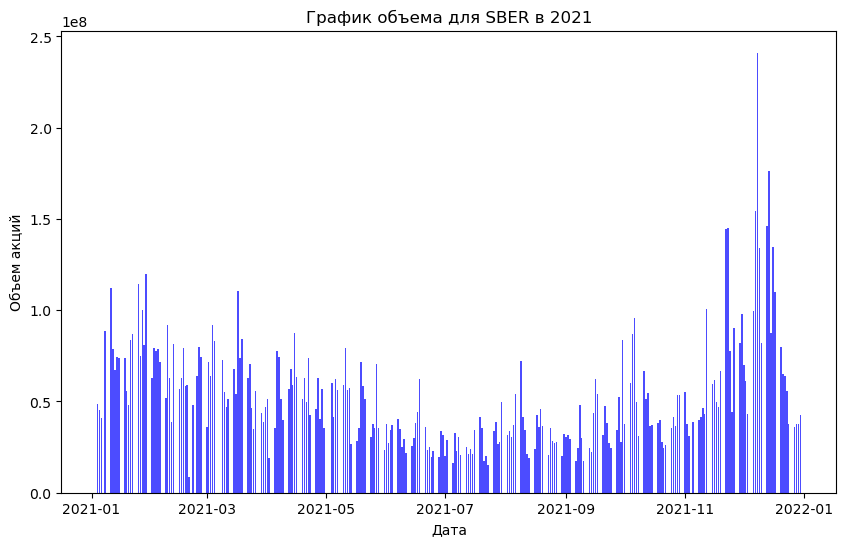

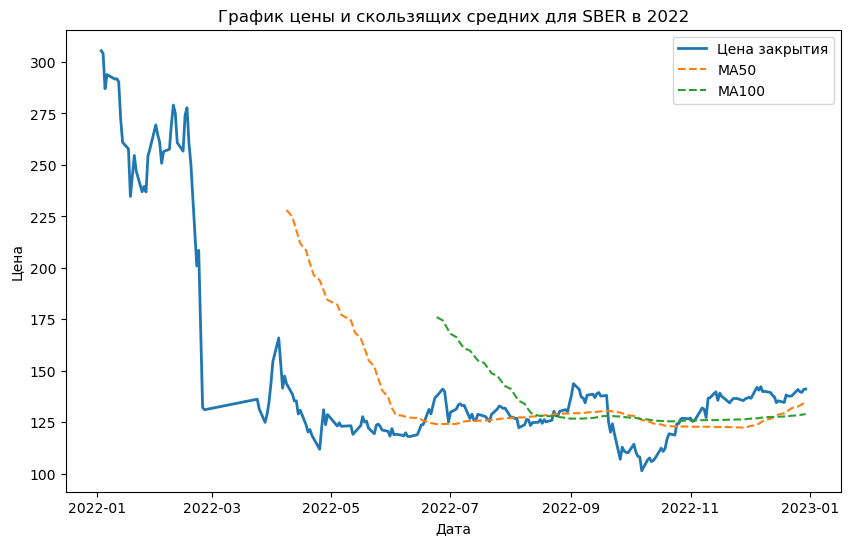

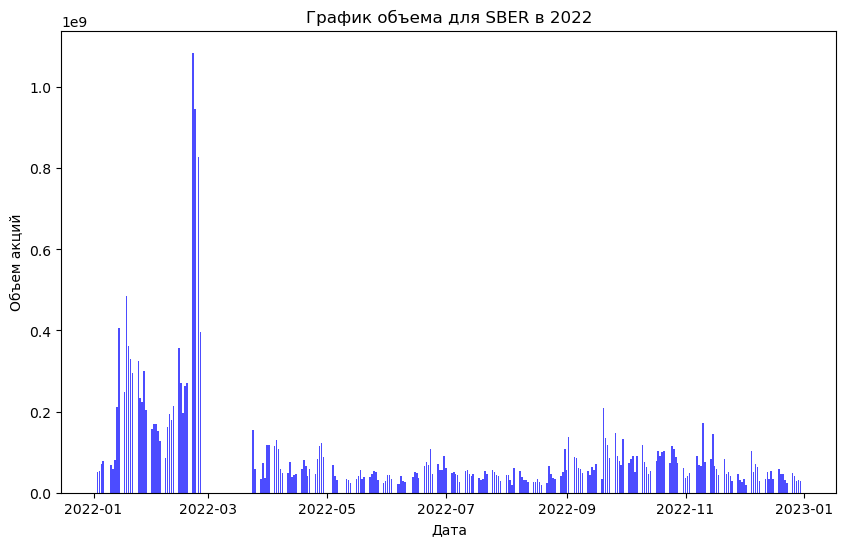

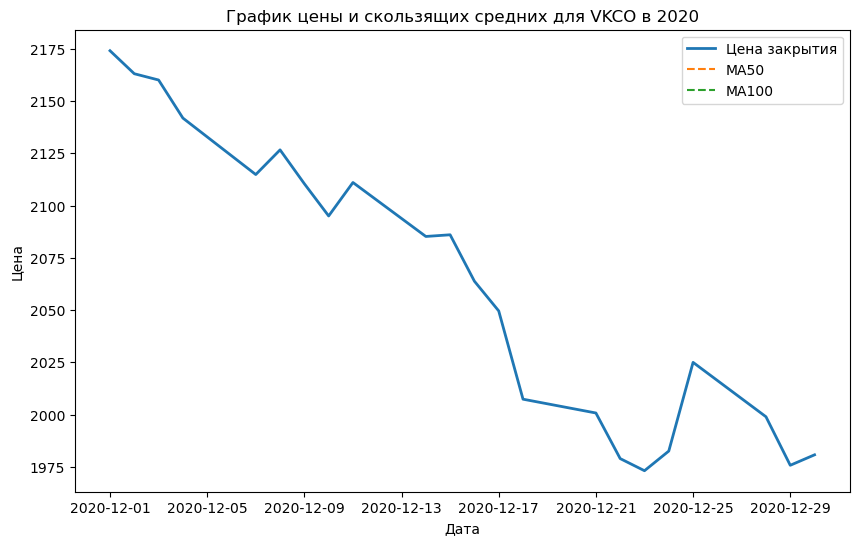

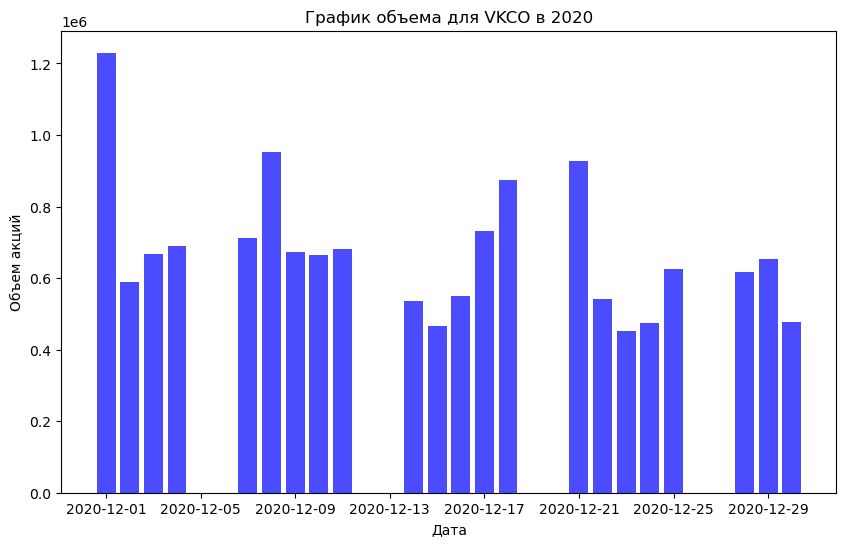

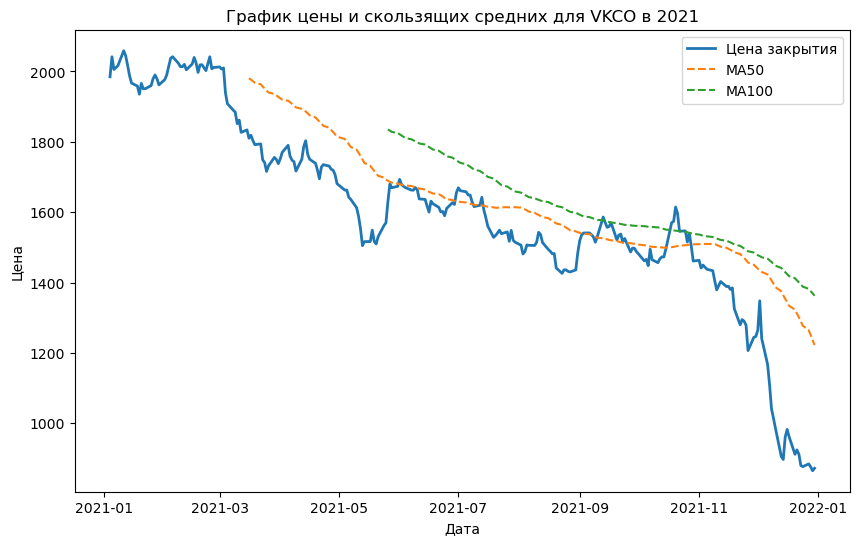

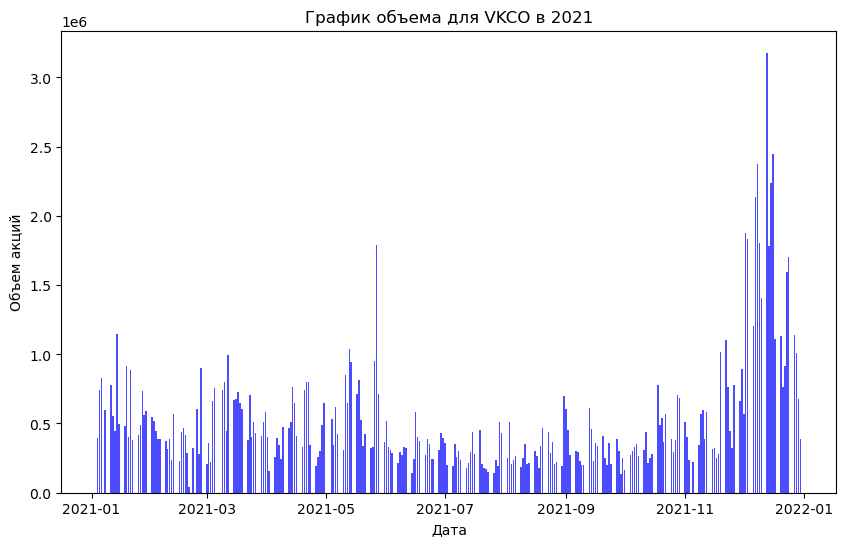

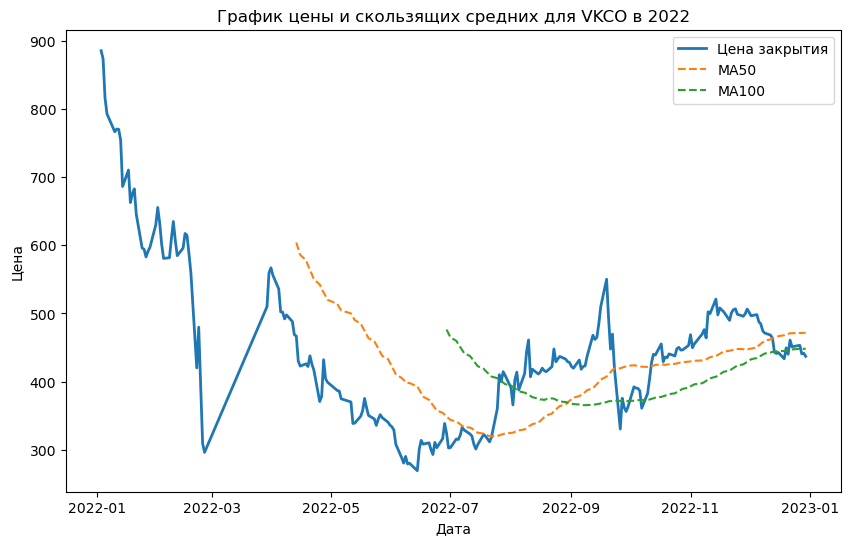

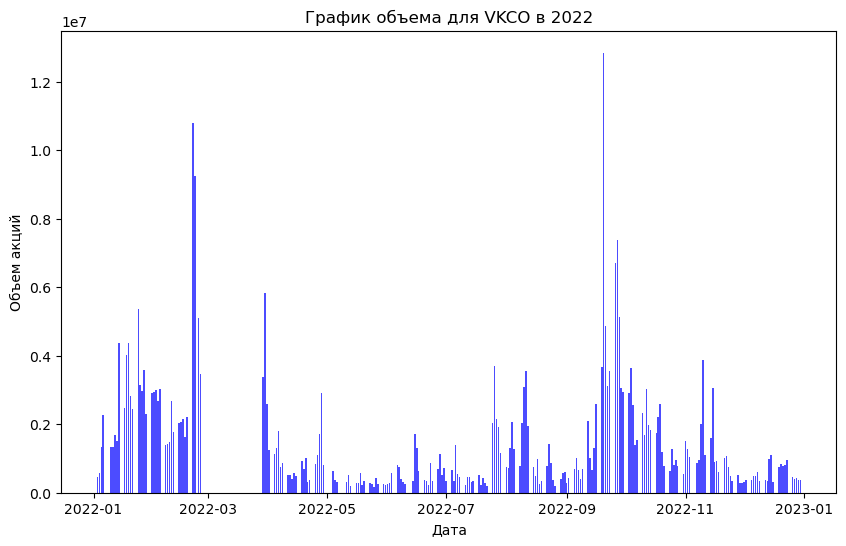

In [30]:
def plot_price_and_volume(ticker, year):
    # Фильтруем данные для конкретного тикера и года
    subset = df[(df['ticker'] == ticker) & (df['date'].dt.year == year)].copy()
    # Добавляем столбцы с различными скользящими средними
    subset['MA50'] = subset['close'].rolling(window=50).mean()
    subset['MA100'] = subset['close'].rolling(window=100).mean()
    # Строим графики цены и скользящих средних
    plt.figure(figsize=(10, 6))
    plt.plot(subset['date'], subset['close'], label='Цена закрытия', linewidth=2)
    plt.plot(subset['date'], subset['MA50'], label='MA50', linestyle='--')
    plt.plot(subset['date'], subset['MA100'], label='MA100', linestyle='--')
    plt.xlabel('Дата')
    plt.ylabel('Цена')
    plt.title(f'График цены и скользящих средних для {ticker} в {year}')
    plt.legend()
    plt.show()
    # Строим график объема
    plt.figure(figsize=(10, 6))
    plt.bar(subset['date'], subset['vol'], color='blue', alpha=0.7)
    plt.xlabel('Дата')
    plt.ylabel('Объем акций')
    plt.title(f'График объема для {ticker} в {year}')
    plt.show()

# Применим функцию
tickers = df['ticker'].unique()
years = range(2020, 2023)
for ticker in tickers:
    for year in years:
        plot_price_and_volume(ticker, year)

### 9. Добавьте экспоненциальные скользящие средние для каждого тикера с периодом 50.

In [25]:
for ticker in df['ticker'].unique():
    subset = df[df['ticker'] == ticker]
    # Добавляем столбец с экспоненциальным скользящим средним (EMA) с периодом 50
    subset['EMA50'] = subset['close'].ewm(span=50, adjust=False).mean()
    # Выводим обновленный DataFrame
    print(subset)

     index ticker       date    open    high     low   close       vol  \
0        0   GAZP 2020-12-01  182.60  188.09  181.78  185.34  67193810   
1        1   GAZP 2020-12-02  185.00  187.24  183.12  187.22  40191320   
2        2   GAZP 2020-12-03  186.98  187.58  184.37  185.12  35885290   
3        3   GAZP 2020-12-04  186.20  189.42  185.85  188.79  50684840   
4        4   GAZP 2020-12-07  188.22  192.85  187.80  190.76  53512780   
..     ...    ...        ...     ...     ...     ...     ...       ...   
740    740   GAZP 2023-11-27  165.10  165.37  162.01  162.79  23665130   
741    741   GAZP 2023-11-28  162.82  164.83  161.55  164.21  16806780   
742    742   GAZP 2023-11-29  164.00  165.63  162.71  163.17  17297850   
743    743   GAZP 2023-11-30  163.17  164.62  162.12  163.23  12305730   
744    744   GAZP 2023-12-01  163.22  164.22  162.56  162.61  10923950   

     price_change       EMA50  
0            2.74  185.340000  
1            2.22  185.413725  
2           -1.

C:\Users\Nastia\AppData\Local\Temp\ipykernel_6036\3648686973.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['EMA50'] = subset['close'].ewm(span=50, adjust=False).mean()
C:\Users\Nastia\AppData\Local\Temp\ipykernel_6036\3648686973.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['EMA50'] = subset['close'].ewm(span=50, adjust=False).mean()
C:\Users\Nastia\AppData\Local\Temp\ipykernel_6036\3648686973.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

Осуществление на графиках:

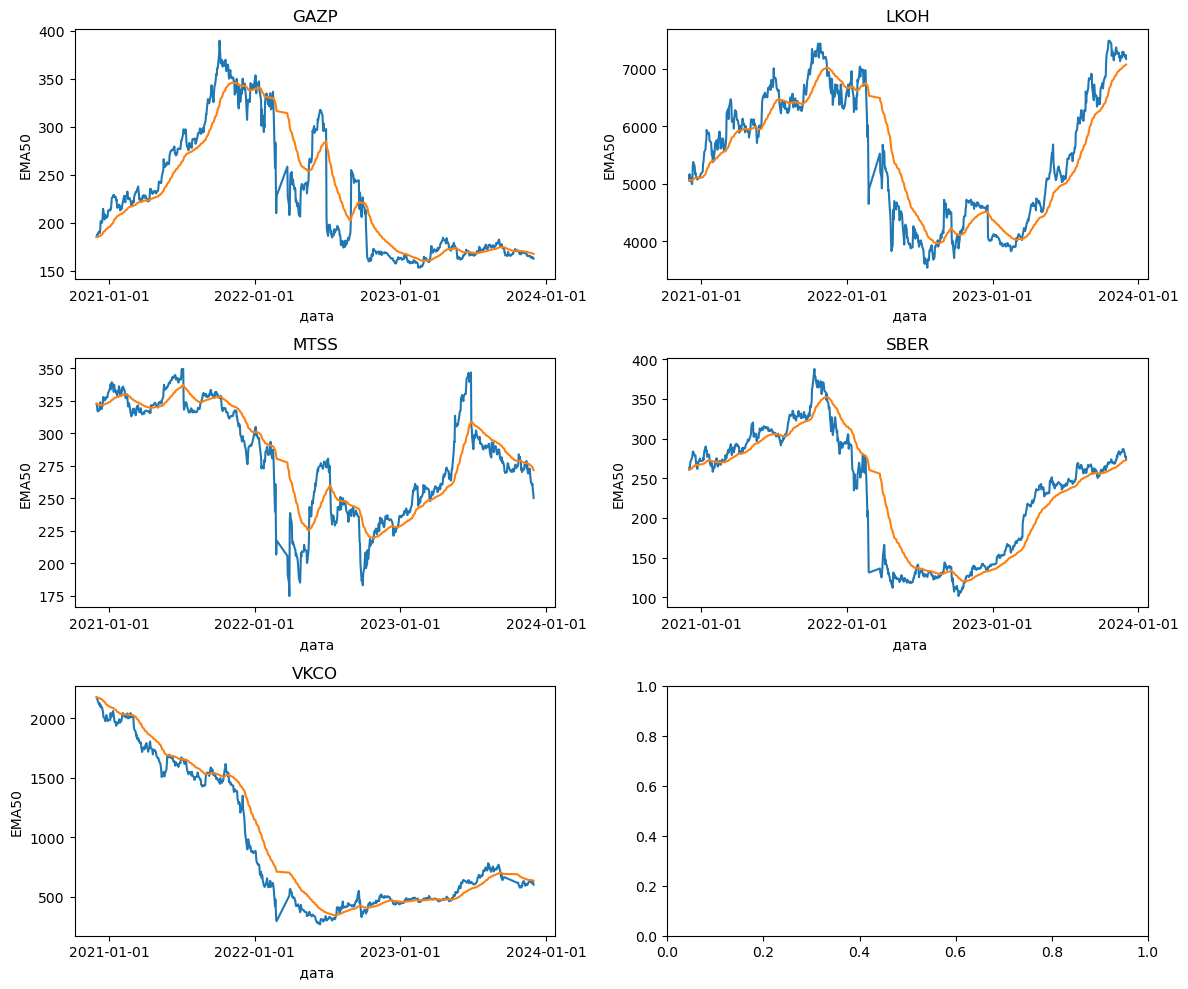

In [31]:
fig,axes = plt.subplots(3, 2, figsize = (12, 10))

for ticker, ax in zip(df['ticker'].unique(), axes.ravel()):
    subset = df[df['ticker'] == ticker].copy()
    subset['EMA50'] = subset['close'].ewm(span=50, adjust=False).mean()
    sns.lineplot(data = subset, x = 'date', y = 'close', ax = ax).set(title = ticker, xlabel = ' дата', ylabel = 'цена закрытия', xticks = [dt(2021+i,1,1) for i in range(4)])
    sns.lineplot(data = subset, x = 'date', y = 'EMA50', ax = ax).set(title = ticker, xlabel = ' дата', ylabel = 'EMA50', xticks = [dt(2021+i,1,1) for i in range(4)])
plt.tight_layout()

Графики экспоненциальных скользящих средних получились более плавными, чем графики фактических цен акций, но они слишком удалены от реальных значений стоимости акций компаний Газпрома, Лукойла, МТС и Сбербанка, а вот график экспоненциальных скользящих средних для Вконтакте повторяет значения лучше, особенно в период с июля 2022 года

### 10. Осуществите расчет индикатора RSI.

In [28]:
for ticker in df['ticker'].unique():
    subset = df[df['ticker'] == ticker]
    # Рассчитываем изменение цены
    subset['price_change'] = subset['close'].diff()
    # Выделяем положительные и отрицательные изменения цены
    subset['gain'] = subset['price_change'].apply(lambda x: x if x > 0 else 0)
    subset['loss'] = subset['price_change'].apply(lambda x: -x if x < 0 else 0)
    # Рассчитываем средний прирост и средний убыток с использованием экспоненциального сглаживания
    avg_gain = subset['gain'].ewm(span=14, adjust=False).mean()
    avg_loss = subset['loss'].ewm(span=14, adjust=False).mean()
    # Рассчитываем относительную силу (RS)
    rs = avg_gain / avg_loss
    # Рассчитываем индикатор RSI
    rsi = 100 - (100 / (1 + rs))
    subset['RSI'] = rsi
    print(subset)

     index ticker       date    open    high     low   close       vol  \
0        0   GAZP 2020-12-01  182.60  188.09  181.78  185.34  67193810   
1        1   GAZP 2020-12-02  185.00  187.24  183.12  187.22  40191320   
2        2   GAZP 2020-12-03  186.98  187.58  184.37  185.12  35885290   
3        3   GAZP 2020-12-04  186.20  189.42  185.85  188.79  50684840   
4        4   GAZP 2020-12-07  188.22  192.85  187.80  190.76  53512780   
..     ...    ...        ...     ...     ...     ...     ...       ...   
740    740   GAZP 2023-11-27  165.10  165.37  162.01  162.79  23665130   
741    741   GAZP 2023-11-28  162.82  164.83  161.55  164.21  16806780   
742    742   GAZP 2023-11-29  164.00  165.63  162.71  163.17  17297850   
743    743   GAZP 2023-11-30  163.17  164.62  162.12  163.23  12305730   
744    744   GAZP 2023-12-01  163.22  164.22  162.56  162.61  10923950   

     price_change  gain  loss         RSI  
0             NaN  0.00  0.00         NaN  
1            1.88  1.88

C:\Users\Nastia\AppData\Local\Temp\ipykernel_6036\1524175844.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['price_change'] = subset['close'].diff()
C:\Users\Nastia\AppData\Local\Temp\ipykernel_6036\1524175844.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['gain'] = subset['price_change'].apply(lambda x: x if x > 0 else 0)
C:\Users\Nastia\AppData\Local\Temp\ipykernel_6036\1524175844.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

### 11. Создайте функцию для вывода графиков: цены, скользящей средней (тип и период определите самостоятельно) и отдельный график для RSI индикатора. На графике с RSI добавьте две красные линии на уровнях 70 и 30. На вход функция принимает два параметра: тикер и год.

In [35]:
def plot_price_sma_rsi(ticker, year):
    subset = df[(df['ticker'] == ticker) & (df['date'].dt.year == year)].copy()
    # Добавляем столбец с выбранной скользящей средней
    subset['SMA'] = subset['close'].rolling(window=20).mean()
    # Рассчитываем изменение цены
    subset['price_change'] = subset['close'].diff()
    # Выделяем положительные и отрицательные изменения цены
    subset['gain'] = subset['price_change'].apply(lambda x: x if x > 0 else 0)
    subset['loss'] = subset['price_change'].apply(lambda x: -x if x < 0 else 0)
    # Рассчитываем средний прирост и средний убыток с использованием экспоненциального сглаживания
    avg_gain = subset['gain'].ewm(span=14, adjust=False).mean()
    avg_loss = subset['loss'].ewm(span=14, adjust=False).mean()
    # Рассчитываем относительную силу (RS)
    rs = avg_gain / avg_loss
    # Рассчитываем индикатор RSI
    rsi = 100 - (100 / (1 + rs))
    # Строим графики
    fig,axes = plt.subplots(1,2, figsize = (12,6))
    axes[0].plot(subset['date'], subset['close'], label='Цена закрытия', linewidth=2)
    axes[0].plot(subset['date'], subset['SMA'], label='SMA(20)', linestyle='--')


    # График RSI с уровнями 70 и 30
    axes[1].plot(subset['date'], rsi, label='RSI(14)', color='blue')
    axes[1].axhline(y=70, color='green', linestyle='--', label='Overbought (70)')
    axes[1].axhline(y=30, color='red', linestyle='--', label='Oversold (30)')
    
    axes[0].title.set_text('Цена закрытия, скользящие средние')
    axes[1].title.set_text('RSI, окно между 30 и 70')
    plt.suptitle(f"Для {ticker}")


    plt.show()

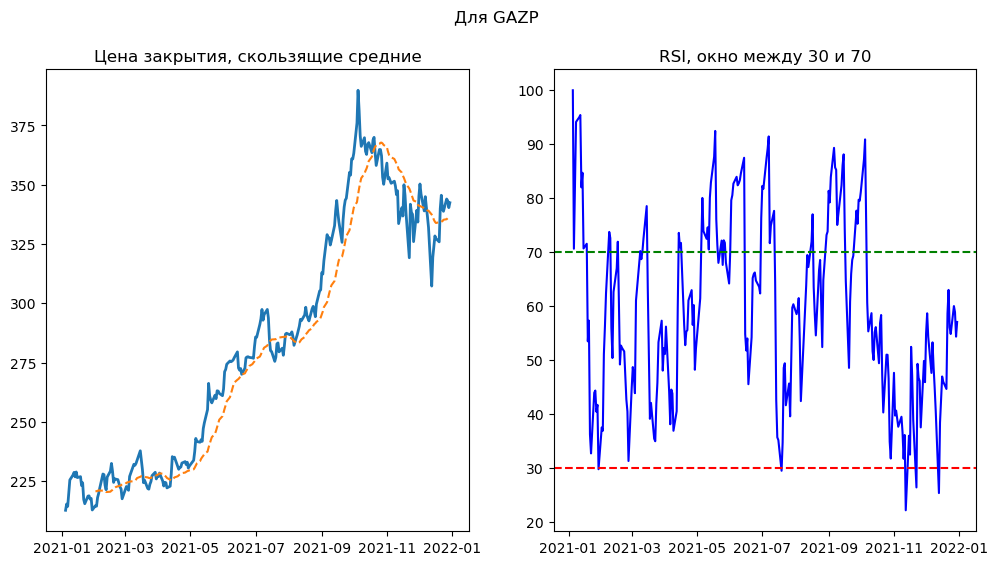

In [36]:
plot_price_sma_rsi(df['ticker'].unique()[0], 2021)

### Модель прогноза

Так как для анализа дан временной ряд в качестве модели для предсказаня можно использовать экспоненциальное сглаживание

In [40]:
from statsmodels.tsa.api import ExponentialSmoothing

In [41]:
predict = df[df['ticker'] == ticker]['close']

In [43]:
model_pred = ExponentialSmoothing(predict[:-28].to_list(), initialization_method='heuristic', trend = 'add', seasonal_periods = 'add').fit(smoothing_level = 0.5)
model_pred.forecast(14)

array([615.82279269, 613.42011889, 611.01744509, 608.61477129,
       606.21209749, 603.80942368, 601.40674988, 599.00407608,
       596.60140228, 594.19872848, 591.79605468, 589.39338087,
       586.99070707, 584.58803327])

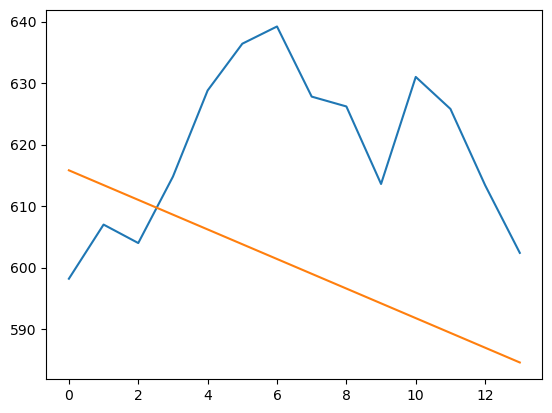

In [45]:
plt.plot(predict[-14:].to_list())
plt.plot(model_pred.forecast(14))

График получился очень странным, посмотрим на ошибку

In [47]:
from sklearn.metrics import mean_squared_error
mean_squared_error(predict[-14:], model_pred.forecast(14))

671.3407723607991

По полученной ошибки, можно сказать что модель не омжет быть применена к имеющимся данным